# Fast Forward Review of Spark

# Table of Contents
* [Installation of Spark](#Installation-of-Spark)
* [Spark Context](#Spark-Context)
    * [Create A RDD](#Create-A-RDD)
    * [Call `collect` on an RDD: Lazy Spark](#Call-collect-on-an-RDD:-Lazy-Spark)
    * [Operations on RDDs](#Operations-on-RDDs)
    * [Word Examples](#Word-Examples)
    * [Key Value Pairs](#Key-Value-Pairs)
    * [word count  `reduceByKey()`](#WORD-COUNT!)
    * [Nested Syntax](#Nested-Syntax)
    * [Using Cache](#Using-Cache)
    * [Fun with words](#Fun-with-words)
    * [DataFrames](#DataFrames)


# Installation of Spark

### Install Apache Spark as per instructions

Refer the `README.md` file below 

https://github.com/nipunsadvilkar/hands-on-spark/blob/master/README.md

# Spark Context

If you have configured Apache Spark on your machine successfully then go ahead and type command `pyspark` to open up Ipython notebook in your browser.

Since we initiated from `pyspark` command, instance of `SparkContext` will be available to us. 
If you have followed another method then use `findspark`. Initiating `SparkContext` in that case would be as follows:

```python
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext()
```

> you may need to pass `spark_home` path to `init` method call

Example:

`findspark.init(spark_home='/Users/nipunsadvilkar/tools/spark-2.2.1-bin-hadoop2.7')`

### Test to see if you have access to `sc` variable which is `SparkContext` instance

In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

# Starting with simple example

In [2]:
sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).map(lambda x: x**2).sum()

385

### Create A RDD


In [3]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
# splitting into 4 slices
wordsRDD = sc.parallelize(wordsList, 4)
# Print out the type of wordsRDD
print(type(wordsRDD))

<class 'pyspark.rdd.RDD'>


### Call `collect` on an RDD: Lazy Spark

Spark is lazy. Until you `collect`, nothing is actually run.

>Instead, they just remember the transformations applied to some base dataset (e.g. a file). The transformations are only computed when an action requires a result to be returned to the driver program.

In [11]:
wordsRDD.collect()
# nothing goes above it's just returning given list as it is (Stupid Program :-P)

['cat', 'elephant', 'rat', 'rat', 'cat']

## Operations on RDDs

From the Spark Programming Guide:

>RDDs support two types of operations: transformations, which create a new dataset from an existing one, and actions, which return a value to the driver program after running a computation on the dataset.

For example,

1. `map` is **a transformation** that passes each dataset element through a function and returns a new RDD representing the results.
2. `reduce` is **an action** that aggregates all the elements of the RDD using some function and returns the final result to the driver program (although there is also a parallel reduceByKey that returns a distributed dataset).

### Word Examples

In [4]:
def makePlural(word):
    return word + 's'

print(makePlural('cat'))

cats


> Notice that above function doesnt change any state it takes something, does transformation and returns something else

Transform one RDD into another.

In [5]:
pluralRDD = wordsRDD.map(makePlural)
print(pluralRDD.first())
print(pluralRDD.take(2))


cats
['cats', 'elephants']


In [6]:
pluralRDD.take(1)

['cats']

In [7]:
pluralRDD.collect()

['cats', 'elephants', 'rats', 'rats', 'cats']

> Look at sparkUI and you'll see `wordsRDD` is running this `map` -> `runJob` entirely on 4 different thread on my machine. Which is actually an overkill but it's just for demonstartion!

### Key Value Pairs

In [8]:
wordPairs = wordsRDD.map(lambda w: (w, 1))
print(wordPairs.collect())

[('cat', 1), ('elephant', 1), ('rat', 1), ('rat', 1), ('cat', 1)]


### WORD COUNT!

In [26]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
wordCountsCollected = (wordsRDD
                       .map(lambda w: (w, 1))
                       .reduceByKey(lambda x,y: x+y)
                       .collect())
print(wordCountsCollected)

[('cat', 2), ('elephant', 1), ('rat', 2)]


![Tons of shuffling](https://databricks.gitbooks.io/databricks-spark-knowledge-base/content/images/reduce_by.png)


> Spark Framework decide in what fashion to split the data

In [31]:
print((wordsRDD
    .map(lambda w: (w, 1))
    .reduceByKey(lambda x,y: x+y)).toDebugString().decode('UTF-8'))

(4) PythonRDD[58] at RDD at PythonRDD.scala:48 []
 |  MapPartitionsRDD[57] at mapPartitions at PythonRDD.scala:436 []
 |  ShuffledRDD[56] at partitionBy at NativeMethodAccessorImpl.java:0 []
 +-(4) PairwiseRDD[55] at reduceByKey at <ipython-input-31-8b78b347e2c9>:3 []
    |  PythonRDD[54] at reduceByKey at <ipython-input-31-8b78b347e2c9>:3 []
    |  ParallelCollectionRDD[28] at parallelize at PythonRDD.scala:489 []


### Using Cache

In [9]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
wordsRDD.count()

# again until `count` is being called it logs what needs to be called one after the another
# and once `count` gets called it runs all those

5

In [11]:
# entire program from start will run again
wordsRDD.count()

5

In [12]:
#default storage level (MEMORY_ONLY)
wordsRDD.cache()#nothing done this is still lazy

ParallelCollectionRDD[9] at parallelize at PythonRDD.scala:489

In [13]:
#parallelize is rerun and cached because we told it to cache
wordsRDD.count()

5

In [40]:
#this `sc.parallelize` is not rerun in this case
wordsRDD.count()

5

> Checkout spark UI you'll see it's being cached


![cached](../img/cached.png "Cached")

Where is this useful: it is when you have branching parts or loops, so that you dont do things again and again. Spark, being "lazy" will rerun the chain again. So `cache` or `persist` serves as a checkpoint, breaking the RDD chain or the *lineage*.

In [14]:
birds_list=['heron','owl']
anim_list = wordsList + birds_list
animaldict={}
for e in wordsList:
    animaldict[e]='mammal'
for e in birds_list:
    animaldict[e]='bird'
animaldict

{'cat': 'mammal',
 'elephant': 'mammal',
 'heron': 'bird',
 'owl': 'bird',
 'rat': 'mammal'}

In [46]:
animsrdd = sc.parallelize(anim_list, 4)
animsrdd.cache()
# below runs the whole chain but causes cache to be populated
mammalcount=animsrdd.filter(lambda w: animaldict[w]=='mammal').count()
# now only the filter is carried out
birdcount=animsrdd.filter(lambda w: animaldict[w]=='bird').count()
print(mammalcount, birdcount)

5 2


> that second filter operation for `birdcount` didn't run all the way from the top. It took that cached `animsrdd` and ran the operation which saved computation and in a way speeded up the things

### Fun with words

Read http://spark.apache.org/docs/latest/programming-guide.html .

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [16]:
stopwords=[e.strip() for e in open("../data/english.stop.txt").readlines()]

In [18]:
juliusrdd=sc.textFile("../data/shakes/juliuscaesar.txt")

In [22]:
juliusrdd.collect()

['1599',
 'THE TRAGEDY OF JULIUS CAESAR',
 '',
 'by William Shakespeare',
 '',
 '',
 '',
 'Dramatis Personae',
 '',
 '  JULIUS CAESAR, Roman statesman and general',
 "  OCTAVIUS, Triumvir after Caesar's death, later Augustus Caesar,",
 '    first emperor of Rome',
 '  MARK ANTONY, general and friend of Caesar, a Triumvir after his',
 'death',
 '  LEPIDUS, third member of the Triumvirate',
 '  MARCUS BRUTUS, leader of the conspiracy against Caesar',
 '  CASSIUS, instigator of the conspiracy',
 '  CASCA,          conspirator against Caesar',
 '  TREBONIUS,           "          "     "',
 '  CAIUS LIGARIUS,      "          "     "',
 '  DECIUS BRUTUS,       "          "     "',
 '  METELLUS CIMBER,     "          "     "',
 '  CINNA,               "          "     "',
 '  CALPURNIA, wife of Caesar',
 '  PORTIA, wife of Brutus',
 '  CICERO,     senator',
 '  POPILIUS,      "',
 '  POPILIUS LENA, "',
 '  FLAVIUS, tribune ',
 '  MARULLUS, tribune',
 '  CATO,     supportor of Brutus',
 '  LUC

In [23]:
juliusrdd.flatMap(lambda line: line.split()).count()

21245

In [24]:
(juliusrdd.flatMap(lambda line: line.split())
 .map(lambda word: word.strip().lower())
  .take(10)
)

['1599',
 'the',
 'tragedy',
 'of',
 'julius',
 'caesar',
 'by',
 'william',
 'shakespeare',
 'dramatis']

## Quiz

### Will above cell run all the operations from start or just take input from previous line and do operation?

In [26]:
(juliusrdd.flatMap(lambda line: line.split())
 .map(lambda word: word.strip().lower())
 .filter(lambda word: word not in stopwords)
 .take(20)
)

# take is a reducer i.e., "Action"

['1599',
 'tragedy',
 'julius',
 'caesar',
 'william',
 'shakespeare',
 'dramatis',
 'personae',
 'julius',
 'caesar,',
 'roman',
 'statesman',
 'general',
 'octavius,',
 'triumvir',
 "caesar's",
 'death,',
 'augustus',
 'caesar,',
 'emperor']

In [27]:
(juliusrdd.flatMap(lambda line: line.split())
 .map(lambda word: word.strip().lower())
 .filter(lambda word: word not in stopwords)
 .map(lambda word: (word, 1))
 .take(20)
)

[('1599', 1),
 ('tragedy', 1),
 ('julius', 1),
 ('caesar', 1),
 ('william', 1),
 ('shakespeare', 1),
 ('dramatis', 1),
 ('personae', 1),
 ('julius', 1),
 ('caesar,', 1),
 ('roman', 1),
 ('statesman', 1),
 ('general', 1),
 ('octavius,', 1),
 ('triumvir', 1),
 ("caesar's", 1),
 ('death,', 1),
 ('augustus', 1),
 ('caesar,', 1),
 ('emperor', 1)]

In [28]:
(juliusrdd.flatMap(lambda line: line.split())
 .map(lambda word: word.strip().lower())
 .filter(lambda word: word not in stopwords)
 .map(lambda word: (word, 1))
 .reduceByKey(lambda a, b: a + b)
 .take(20)
)

[('him-let', 1),
 ('fire!', 1),
 ('matter;', 1),
 ('head', 2),
 ('dark', 1),
 ('avoided', 1),
 ("fear'd", 2),
 ('dull,', 1),
 ('choked', 2),
 ('tents', 1),
 ("engender'd", 1),
 ('benefit', 1),
 ("bay'd,", 1),
 ('brutus.', 211),
 ('law', 1),
 ('behold', 4),
 ('proof', 3),
 ('aside.', 1),
 ('coming,', 1),
 ('arose', 1)]

In [29]:
(juliusrdd.flatMap(lambda line: line.split())
 .map(lambda word: word.strip().lower())
 .filter(lambda word: word not in stopwords)
 .map(lambda word: (word, 1))
 .reduceByKey(lambda a, b: a + b)
 .takeOrdered(20, lambda x: -x[1]) # negative of second element - descending sort
)

[('brutus.', 211),
 ('cassius.', 152),
 ('thou', 107),
 ('caesar', 96),
 ('brutus', 75),
 ('antony.', 73),
 ('citizen.', 68),
 ('good', 66),
 ('caesar.', 62),
 ('thy', 54),
 ('brutus,', 54),
 ('caesar,', 46),
 ('"', 44),
 ('casca.', 44),
 ('you,', 41),
 ('men', 41),
 ("caesar's", 40),
 ('enter', 40),
 ('lucius.', 38),
 ('cassius,', 38)]

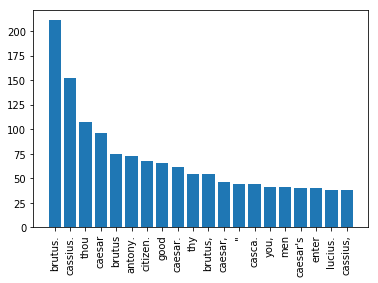

In [30]:
captions, counts=zip(*juliusrdd.flatMap(lambda line: line.split())
 .map(lambda word: word.strip().lower())
 .filter(lambda word: word not in stopwords)
 .map(lambda word: (word, 1))
 .reduceByKey(lambda a, b: a + b)
 .takeOrdered(20, lambda x: -x[1])
)
pos = np.arange(len(counts))
plt.bar(pos, counts);
plt.xticks(pos, captions, rotation=90);

## Run it on all plays of Shakespeare

In [34]:
shakesrdd=sc.textFile("../data/shakes/*.txt", minPartitions=4)

In [35]:
shakesrdd.take(10)

['1601',
 'AS YOU LIKE IT',
 '',
 'by William Shakespeare',
 '',
 '',
 '',
 'DRAMATIS PERSONAE.',
 '',
 '']

In [37]:
(shakesrdd.flatMap(lambda line: line.split())
 .map(lambda word: word.strip().lower())
 .filter(lambda word: word not in stopwords)
 .map(lambda word: (word, 1))
 .reduceByKey(lambda a, b: a + b)
 .take(30)
)

[('mistempered', 1),
 ('mad', 58),
 ('crocodile.--', 1),
 ('[draws,', 1),
 ('suppliest', 1),
 ('head', 101),
 ('being:', 1),
 ('warning', 4),
 ('lapsed', 1),
 ('lease', 1),
 ("prince's", 8),
 ('weakens,', 1),
 ('elected', 2),
 ('nobleman,', 1),
 ('done:', 4),
 ('serve.', 1),
 ('misprised.', 1),
 ('cost', 9),
 ('liest,', 4),
 ("lying'st", 1),
 ('converting', 1),
 ('wounds,', 5),
 ('embarquements', 1),
 ('window', 5),
 ('impotence', 1),
 ("hermia's:", 2),
 ('pluck', 42),
 ('invention', 3),
 ("cousin.'", 1),
 ('remorseful', 1)]

`SparkContext.wholeTextFile`...

>lets you read a directory containing multiple small text files, and returns each of them as (filename, content) pairs - which is called **PairedRDD**. This is in contrast with textFile, which would return one record per line in each file.

### DataFrames

Convert Spark DataFrame to Pandas

`pandas_df = spark_df.toPandas()`

Create a Spark DataFrame from Pandas

```python
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

spark_df = sqlContext.createDataFrame(pandas_df)
```

> **KEEP in mind that it MUST fit in memory.**



# Quiz
    
### Would you be able to create new column in spark DataFrame as you do in pandas DataFrame? Why?

# Let's move on to the exercise